In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm import tqdm
from geohash import encode
# from sklearn.feature_extraction import FeatureHasher
# from sklearn.metrics.pairwise import cosine_similarity

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

cache_dir='cache'
flag=True

## 加载数据

In [2]:
geo_precision=[7,8,9]

# 将经纬度geohash编码
def make_geohash(df,precision=[7]):
    for p in precision:
        df['geohash_%d'%p]=[encode(coor[0],coor[1],p) for coor in tqdm(df[['latitude','longitude']].values)]
    return df

# 提取时间结构信息
def make_struct_time(df):
    time_infos=[]
    for t in tqdm(df.time_stamp):
        _struct_time=time.strptime(t,'%Y-%m-%d %H:%M')
        time_infos.append([_struct_time.tm_hour+_struct_time.tm_min/60.,_struct_time.tm_hour,_struct_time.tm_wday])
    time_infos=pd.DataFrame(time_infos,columns=['time','hour','wday'])
    df=pd.concat((df,time_infos),axis=1)
    return df

# 按照强度降序排列wifi_bssid
def make_wifi_sorted(df,how='max',cache=False):
    cache_path=os.path.join(cache_dir,'加载数据','wifi_sorted_%d_%s.hdf'%(df.shape[0],how))
    if os.path.exists(cache_path) & flag & cache:
        result=pd.read_hdf(cache_path,'data')
    else:
        print('wifi_bssid %s排序中...'%how)
        def _sort_wifi(wifi_infos):
            d={}
            for i in wifi_infos.split(';'):
                infos=i.split('|')[:2] # ['bssid','strength']
                strength=int(infos[1])
                if infos[0] not in d:
                    d.update({infos[0]:[strength]})
                else:
                    d[infos[0]].append(strength)
            _agg=(lambda x:np.mean(x)) if how=='mean' else (lambda x:np.max(x))
            _serialize=lambda x:';'.join(['%s|%d'%(i[0],i[1]) for i in x]) # 序列化
            d=[(i[0],_agg(i[1])) for i in d.items()]
            return _serialize(sorted(d,key=lambda x:x[1],reverse=True))
        result=df.wifi_infos.apply(_sort_wifi)
        if cache:
            result.to_hdf(cache_path,'data')
    def _deserialize(x):
        # 反序列化
        result=[]
        for i in x.split(';'):
            ls=i.split('|')
            ls[1]=int(ls[1])
            result.append(ls)
        return result
    df['wifi_sorted_%s'%how]=result.apply(_deserialize)
    return df

# 加载数据
def load_data(file_path):
    df=pd.read_csv(file_path)
#     df=make_geohash(df,geo_precision)
    df=make_struct_time(df)
    df=make_wifi_sorted(df,'max',True)
    return df

meta_df=pd.read_csv('data/训练数据-ccf_first_round_shop_info.csv')
# meta_df=make_geohash(meta_df,geo_precision)
train_df=load_data('data/训练数据-ccf_first_round_user_shop_behavior.csv')
test_df=load_data('data/AB榜测试集-evaluation_public.csv')

# 加入商铺信息（测试集此时还没有候选集，没有shop_id）
# meta_df.rename(columns={'geohash_6':'_geohash_6'},inplace=True)
train_df=pd.merge(train_df,meta_df[['shop_id','mall_id','category_id','price']],on='shop_id',how='left')
train_df['row_id']=train_df.index

100%|██████████| 483931/483931 [00:04<00:00, 108340.33it/s]


In [3]:
# # 标记出手机定位不可信的样本
# train_df['unbelievable']=(train_df.geohash_6!=train_df._geohash_6)*1
# _match=pd.merge(test_df[['row_id','geohash_6','mall_id']],meta_df[['_geohash_6','shop_id','mall_id']],on='mall_id',how='left')
# _match['equal']=(_match.geohash_6==_match._geohash_6)*1
# _match=_match[['row_id','equal']].groupby('row_id',as_index=False)['equal'].agg({'nb_equal':'sum'})
# _match=_match[_match.nb_equal==0]
# _match.rename(columns={'nb_equal':'unbelievable'},inplace=True)
# _match.unbelievable=1

# test_df=pd.merge(test_df,_match,on='row_id',how='left')
# test_df.fillna(0,inplace=True)

In [41]:
# train_df=train_df[train_df.mall_id=='m_7800']
# test_df=test_df[test_df.mall_id=='m_7800']
# meta_df=meta_df[meta_df.mall_id=='m_7800']

In [3]:
x_train=train_df

In [3]:
# 构造线下验证集
x_train=train_df[train_df.time_stamp<'2017-08-30 00:00']
x_val=train_df[train_df.time_stamp>='2017-08-30 00:00']

In [5]:
# # x_val & test_df同分布？
# def count_plot(df1,df2,key=None):
#     sns.set({'figure.figsize':(16,4)})
#     fig,axs=plt.subplots(1,2)
#     sns.countplot(data=df1,x=key,ax=axs[0])
#     sns.countplot(data=df2,x=key,ax=axs[1])

# merge_mall_id=lambda df:pd.merge(df,meta_df[['shop_id','mall_id']],on='shop_id',how='left')

# count_plot(x_val,test_df,'hour')
# count_plot(x_val,test_df,'wday')
# count_plot(x_val,test_df,'mall_id')

In [4]:
# 统计每个商场出现的wifi，并筛选掉出现在多个商场的wifi，如ChinaNet
mall_wifi=train_df.groupby('mall_id',as_index=False)['wifi_infos'].agg(lambda x:';'.join(x.wifi_infos))
ls=[]
for i in tqdm(mall_wifi.values):
    ls+=[(i[0],j.split('|')[0]) for j in i[1].split(';')]
mall_wifi=pd.DataFrame(ls,columns=['mall_id','wifi'])
wifi_mall_count=mall_wifi.groupby('wifi',as_index=False)['mall_id'].agg({'_count':lambda x:len(x.unique())})
wifi_mall_count.groupby('_count',as_index=False).count()

100%|██████████| 97/97 [00:05<00:00, 18.93it/s]


,_count,wifi
0,1,395574
1,2,3966
2,3,103
3,4,18
4,5,4
5,6,5
6,7,3
7,9,1
8,10,1
9,14,3


In [5]:
# 筛选掉出现在多个商场中的wifi
def wifi_filter(wifi_infos):
    result=pd.DataFrame([i.split('|')[:2] for i in wifi_infos.split(';')],columns=['wifi','strength'])
    result=pd.merge(result,wifi_mall_count[wifi_mall_count._count>3],on='wifi',how='left')
    result=result[result._count.isnull()]
    return ';'.join(['|'.join(i) for i in result[['wifi','strength']].values])

# 整合每个店铺对应的wi-fi信息
def make_aggregated_wifi(df):
    cache_path=os.path.join(cache_dir,'加载数据','aggregate_wifi_%d.hdf'% df.shape[0])
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        result=df[['shop_id','wifi_infos']].groupby('shop_id',as_index=False).agg(lambda x:';'.join(x)) # x:pd.Series
        print('筛选wifi...')
        result.wifi_infos=result.wifi_infos.apply(wifi_filter)
        result=make_wifi_sorted(result,'max')
        result=make_wifi_sorted(result,'mean')
        result.to_hdf(cache_path,'data')
    return result

train_shop_wifi=make_aggregated_wifi(x_train)
test_shop_wifi=make_aggregated_wifi(train_df)

In [6]:
x_train.head()

,user_id,shop_id,time_stamp,longitude,latitude,wifi_infos,time,hour,wday,wifi_sorted_max,mall_id,category_id,price,row_id
0,u_376,s_2871718,2017-08-06 21:20,122.308291,32.088040,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0
1,u_376,s_2871718,2017-08-06 21:20,122.308162,32.087970,b_6396480|-67|false;b_56328155|-73|false;b_411...,21.333333,21,6,"[[b_6396479, -57], [b_5857369, -57], [b_639648...",m_1409,c_38,42,1
2,u_1041,s_181637,2017-08-02 13:10,117.365255,40.638214,b_8006367|-78|false;b_2485110|-52|false;b_3005...,13.166667,13,2,"[[b_2485110, -52], [b_33503892, -56], [b_35013...",m_4079,c_30,40,2
3,u_1158,s_609470,2017-08-13 12:30,121.134451,31.197416,b_26250579|-73|false;b_26250580|-64|false;b_26...,12.500000,12,6,"[[b_30424471, -60], [b_26250580, -64], [b_2625...",m_6587,c_27,49,3
4,u_1654,s_3816766,2017-08-25 19:50,122.255867,31.351320,b_39004150|-66|false;b_39004148|-58|false;b_21...,19.833333,19,4,"[[b_39004148, -58], [b_39004150, -66], [b_1845...",m_3005,c_6,62,4


## EDA

In [37]:
print('训练集中单条记录最多有{}条wi-fi信息'.format(train_df.wifi_infos.apply(lambda x:len(x.split(';'))).max()))
print('测试集中单条记录最多有{}条wi-fi信息'.format(test_df.wifi_infos.apply(lambda x:len(x.split(';'))).max()))

训练集中单条记录最多有20条wi-fi信息
测试集中单条记录最多有10条wi-fi信息


In [7]:
# 计算两点之间距离
def cal_distance(lat1, lon1, lat2, lon2):
    dx = np.abs(lon1 - lon2)  # 经度差
    dy = np.abs(lat1 - lat2)  # 维度差
    b = (lat1 + lat2) / 2.0
    Lx = 6371004.0 * (dx / 57.2958) * np.cos(b / 57.2958)
    Ly = 6371004.0 * (dy / 57.2958)
    L = (Lx ** 2 + Ly ** 2) ** 0.5
    return L

In [14]:
# 计算手机的定位结果和店铺的坐标的偏差值
diff_dis=cal_distance(train_df['latitude_x'],train_df['longitude_x'],train_df['latitude_y'],train_df['longitude_y'])
diff_dis.describe()
# 大多数情况下手机定位误差并不大（最多几十米的范围），不过也存在很多严重漂移的情况

KeyError: 'latitude_x'

100%|██████████| 1138015/1138015 [00:01<00:00, 605226.24it/s]


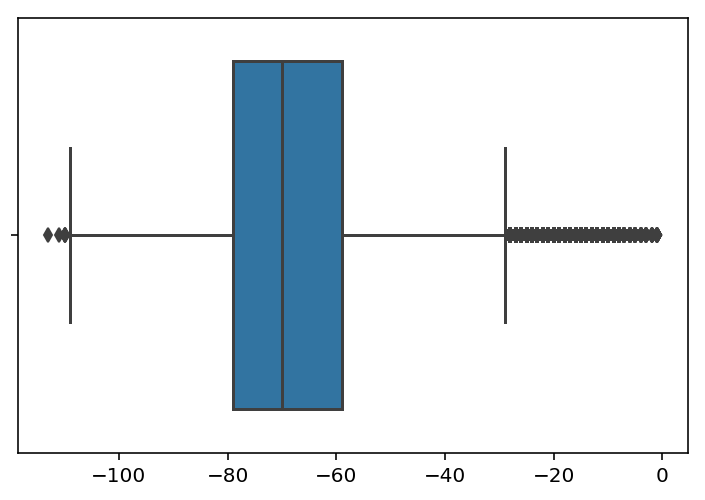

In [9]:
# 训练集wifi强度
wifi_strength=[]
for i in tqdm(train_df.wifi_sorted_max):
    wifi_strength+=[j[1] for j in i]
sns.boxplot(pd.Series(wifi_strength))

## 构造候选shop_id集

In [8]:
# 构造候选集。考虑：用户历史信息、手机+wi-fi定位区域信息

# 7 12831138 98.06315205712107%
# 8 3983675 96.50237426778968%
# 9 1462770 89.19794807805621%
def get_nearby_shops_by_geo(train,test,geo_col='geohash_8'):
    print('加入geohash定位点附近商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','nearby_shops_%d_%s.hdf'%(train.shape[0] * test.shape[0],geo_col))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        shop_locs=train[['mall_id',geo_col,'shop_id']].drop_duplicates() # 减少匹配次数
        result=pd.merge(test[['row_id','mall_id',geo_col]],shop_locs,on=['mall_id',geo_col],how='left')
        result=result[['row_id','shop_id']]
        result.to_hdf(cache_path,'data')
    return result

# 5 231w 94.3%
# 6 212w 94%
# 7 196w 93.8%
# 8 181w 93%
# 10 155w 91%
def get_nearby_shops_by_wifi(df,shop_wifi,geo_col='geohash_7'):
    print('加入wi-fi定位点附近商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','nearby_shops_%d_wifi.hdf'%df.shape[0])
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        result=pd.merge(shop_wifi,meta_df[['shop_id','mall_id',geo_col]],on='shop_id',how='left')
        result=pd.merge(df[['row_id','mall_id',geo_col,'wifi_sorted_max']],result,on=['mall_id',geo_col],how='inner')
        result=result[['row_id','shop_id','wifi_sorted_max_x','wifi_sorted_max_y']]
        result.reset_index()
        # wi-fi交集数
        _set=lambda x:set([i[0] for i in x])
        result['_count']=[len(_set(i[0])&_set(i[1])) for i in tqdm(result[['wifi_sorted_max_x','wifi_sorted_max_y']].values)]
        result.to_hdf(cache_path,'data')
    result=result[['row_id','shop_id']].loc[result._count>=7]
    return result

# def get_shops_by_mall_wifi(df,shop_wifi):
#     print('根据mall和wifi匹配商铺...')
#     df=df[df.unbelievable==1]
#     cache_path=os.path.join(cache_dir,'构造候选','shops_%d_mall_wifi.hdf'%df.shape[0])
#     if os.path.exists(cache_path) & flag:
#         result=pd.read_hdf(cache_path,'data')
#     else:        
#         result=pd.merge(shop_wifi,meta_df[['shop_id','mall_id']],on='shop_id',how='left')
#         result=pd.merge(df[['row_id','mall_id','wifi_sorted_max']],result,on=['mall_id'],how='inner')
#         result=result[['row_id','shop_id','wifi_sorted_max_x','wifi_sorted_max_y']]
#         result.reset_index()
#         # wi-fi交集数
#         _set=lambda x:set([i[0] for i in x])
#         result['_count']=[len(_set(i[0])&_set(i[1])) for i in tqdm(result[['wifi_sorted_max_x','wifi_sorted_max_y']].values)]
#         result.to_hdf(cache_path,'data')
#     result=result.sort_values('_count').groupby('row_id',as_index=False).tail(3)
#     result=result[['row_id','shop_id']]
# #     result=result[['row_id','shop_id']].loc[result._count>=7]
#     return result

def get_user_history_shops(train,test):
    print('加入用户历史商铺...')
    cache_path=os.path.join(cache_dir,'构造候选','user_history_shops_%d.hdf'%(train.shape[0] * test.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        user_history=train[['mall_id','user_id','shop_id']].drop_duplicates() # 减少匹配次数
        result=pd.merge(test[['row_id','mall_id','user_id']],user_history,on=['mall_id','user_id'],how='left')
        result=result[['row_id','shop_id']]
        result.to_hdf(cache_path,'data')
    return result

def make_candidate_shops(train,test,shop_wifi=None,geo_col=None):
    if 'row_id' not in test.columns:
        test['row_id']=test.index
    # 构造候选shop_id集
    nearby_shops_by_geo=get_nearby_shops_by_geo(train,test,geo_col)
    nearby_shops_by_wifi=get_nearby_shops_by_wifi(test,shop_wifi)
#     shops_by_mall_wifi=get_shops_by_mall_wifi(test,shop_wifi)
    user_history_shops=get_user_history_shops(train,test)
    df_set=(nearby_shops_by_geo,nearby_shops_by_wifi,user_history_shops)
    candidate_shops=pd.concat(df_set).drop_duplicates()
    candidate_shops.dropna(inplace=True)
    # 计算覆盖率
    print('共有{}条候选样本'.format(candidate_shops.shape[0]))
    if 'shop_id' in test.columns:
        print('覆盖率{}%'.format(pd.merge(test[['row_id','shop_id']],candidate_shops,on=['row_id','shop_id'],how='inner').shape[0]*100./test.shape[0]))
    print('构造完成...')
    return candidate_shops
    
print('构造训练候选集...')
train_candidate=make_candidate_shops(x_train,x_train,train_shop_wifi,'geohash_9')
train_candidate=pd.concat((train_candidate,x_train[['row_id','shop_id']])).drop_duplicates()
print('构造测试候选集...')
test_candidate=make_candidate_shops(train_df,test_df,test_shop_wifi,'geohash_8')
print('构造验证候选集...')
# val_candidate=make_candidate_shops(x_train,x_val,train_shop_wifi,'geohash_8')

构造训练候选集...
加入geohash定位点附近商铺...


KeyError: "['geohash_9'] not in index"

In [8]:
# 利用多分类模型的结果构造二分类模型的候选集
def make_candidate_shops_by_multi(cache_suffix,nb_candidates=5):
    candidates=[]
    probas=[]
    for mall_id in tqdm(meta_df.mall_id.unique()):
        fname=os.path.join(cache_dir,'multi','{}_{}.hdf'.format(mall_id,cache_suffix))
        cache_file=pd.read_hdf(fname,'data')
        for idx,row in cache_file.iterrows():
            for i in row[-nb_candidates:]:
                candidates.append((idx,i))
        cache_file=pd.read_hdf(fname,'proba')
        probas+=list(cache_file.values[:,-nb_candidates:].flatten())
#         for idx,row in cache_file.iterrows():
#             probas+=list(row[-nb_candidates:])
    result=pd.DataFrame(candidates,columns=['row_id','shop_id'])
    result['proba']=probas
    return result

train_candidate=make_candidate_shops_by_multi('train_full',nb_candidates=5)
# val_candidate=make_candidate_shops_by_multi('val',nb_candidates=5)
test_candidate=make_candidate_shops_by_multi('test',nb_candidates=5)

100%|██████████| 97/97 [01:00<00:00,  1.43it/s]


In [9]:
# 计算覆盖率
print(pd.merge(train_candidate,x_train[['shop_id','row_id']],on=['shop_id','row_id'],how='inner').shape[0]/x_train.shape[0])
# print(pd.merge(val_candidate,x_val[['shop_id','row_id']],on=['shop_id','row_id'],how='inner').shape[0]/x_val.shape[0])
# 7:0.9773179783692518
# 5:0.9723483219445374

0.997136241613687


In [11]:
train_candidate=pd.concat((train_candidate,x_train[['row_id','shop_id']])).drop_duplicates()

## 构造训练/测试基础样本

In [10]:
train_basic=pd.merge(x_train,train_candidate,on='row_id',how='left')
label=(train_basic['shop_id_x']==train_basic['shop_id_y'])*1
train_basic.drop('shop_id_x',axis=1,inplace=True)
train_basic.rename(columns={'shop_id_y':'shop_id'},inplace=True)
train_basic=pd.merge(train_basic,train_shop_wifi,on='shop_id',how='left')

In [39]:
val_basic=pd.merge(x_val,val_candidate,on='row_id',how='left')
val_label=(val_basic['shop_id_x']==val_basic['shop_id_y'])*1
val_basic.drop('shop_id_x',axis=1,inplace=True)
val_basic.rename(columns={'shop_id_y':'shop_id'},inplace=True)
val_basic=pd.merge(val_basic,train_shop_wifi,on='shop_id',how='left')

In [11]:
test_basic=pd.merge(test_df,test_candidate,on='row_id',how='left')
test_basic=pd.merge(test_basic,test_shop_wifi,on='shop_id',how='left')
test_basic=pd.merge(test_basic,meta_df[['shop_id','category_id','price']],on='shop_id',how='left')

In [12]:
train_basic.head()

,user_id,time_stamp,longitude,latitude,wifi_infos_x,time,hour,wday,wifi_sorted_max_x,mall_id,category_id,price,row_id,shop_id,proba,wifi_infos_y,wifi_sorted_max_y,wifi_sorted_mean
0,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_298098,0.000594,b_10687160|-85;b_26685632|-88;b_24303621|-11;b...,"[[b_24303621, -3], [b_16706070, -19], [b_56324...","[[b_24303621, -27], [b_16706070, -41], [b_2994..."
1,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_3699,0.000602,b_56326189|-61;b_30230712|-62;b_25137940|-51;b...,"[[b_30230709, -15], [b_30230710, -25], [b_5632...","[[b_35548532, -32], [b_41781150, -35], [b_1877..."
2,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_20409,0.001060,b_32017375|-38;b_4658235|-81;b_32017374|-23;b_...,"[[b_32017374, -17], [b_32017375, -17], [b_5470...","[[b_32017374, -30], [b_54703901, -35], [b_3201..."
3,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_580441,0.002338,b_8764725|-72;b_8764726|-72;b_1041118|-77;b_25...,"[[b_15278309, -23], [b_32053319, -27], [b_5632...","[[b_15278309, -32], [b_32053319, -38], [b_5632..."
4,u_376,2017-08-06 21:20,122.308291,32.08804,b_6396480|-67|false;b_41124514|-86|false;b_287...,21.333333,21,6,"[[b_6396479, -55], [b_5857369, -55], [b_639648...",m_1409,c_38,42,0,s_2871718,0.981201,b_6396480|-67;b_41124514|-86;b_28723327|-90;b_...,"[[b_26748506, -26], [b_6396479, -43], [b_58573...","[[b_50744804, -49], [b_5857369, -53], [b_63964..."


## 加入特征

In [13]:
flag=False

def apk(actual, predicted, k=10, on_actual=True):
    """
    actual : A list of elements that are to be predicted (order doesn't matter)
    predicted : A list of predicted elements (order does matter)
    """
    if len(predicted)>k:
        predicted = predicted[:k]
    if on_actual and len(actual)>k:
        actual = actual[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def add_shop_count(df1,df2):
    shop_count=df1.groupby('shop_id',as_index=False)['shop_id'].agg({'shop_count':'count'})
    result=pd.merge(df2,shop_count,on='shop_id',how='left')
    return result

def add_mall_heat(df1,df2):
    mall_heat=df1.groupby('mall_id',as_index=False)['mall_id'].agg({'mall_heat':'count'})
    result=pd.merge(df2,mall_heat,on='mall_id',how='left')
    return result

# def add_shop_count_with_time(df1,df2):
#     shop_count_with_time=df1.groupby(['shop_id','hour'],as_index=False)['shop_id'].agg({'shop_count_with_time':'count'})
#     result=pd.merge(df2,shop_count_with_time,on=['shop_id','hour'],how='left')
#     return result

# def add_mall_heat_with_time(df1,df2):
#     mall_heat_with_time=df1.groupby(['mall_id','hour'],as_index=False)['mall_id'].agg({'mall_heat_with_time':'count'})
#     result=pd.merge(df2,mall_heat_with_time,on=['mall_id','hour'],how='left')
#     return result

# def add_user_shop_frequency(df1,df2):
#     user_shop_frequency=df1.groupby(['user_id','shop_id'],as_index=False)['shop_id'].agg({'user_shop_frequency':'count'})
#     result=pd.merge(df2,user_shop_frequency,on=['user_id','shop_id'],how='left')
#     return result

# def add_user_mall_frequency(df1,df2):
#     user_mall_frequency=df1.groupby(['user_id','mall_id'],as_index=False)['mall_id'].agg({'user_mall_frequency':'count'})
#     result=pd.merge(df2,user_mall_frequency,on=['user_id','mall_id'],how='left')
#     return result

def add_user_power(df1,df2):
    user_power=df1.groupby(['user_id'],as_index=False)['price'].agg({'mean_power':'mean'})
    result=pd.merge(df2,user_power,on=['user_id'],how='left')
    return result

def add_category_time(df1,df2):
    category_time=df1[['category_id','time']].groupby(['category_id'],as_index=False)['time'].agg({'category_time':'mean'})
    result=pd.merge(df2,category_time,on='category_id',how='left')
    return result

def add_wifi_apk(df,k=10,on_actual=True,how='max'):
    name='wifi_apk_{}_{}_{}'.format(how,k,on_actual*1)
    cache_path=os.path.join(cache_dir,'构造特征/wifi_apk','{}_{}.hdf'.format(name,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        apks=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        _list=lambda x:[i[0] for i in x[:k]]
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                apks.append(apk(_list(i[1]),_list(i[0]),k,on_actual))
            else:
                apks.append(0)
        result=pd.Series(apks)
        result.to_hdf(cache_path,'data')
    df[name]=result
    return df

def add_wifi_diff(df,how='max'):
    cache_path=os.path.join(cache_dir,'构造特征/wifi_diff','wifi_diff_{}_{}.hdf'.format(how,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        diffs=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                large_sum=large_num=less_sum=less_num=0
                d1=dict(i[0])
                d2=dict(i[1])
                intersection_keys=d1.keys()&d2.keys()
                for key in intersection_keys:
                    value1=d1[key]
                    value2=d2[key]
                    if value1>=value2:
                        large_sum+=(value1-value2) # 越大越好
                        large_num+=1
                    else:
                        less_sum+=(value2-value1) # 越小越好
                        less_num+=1
                large_sum=large_sum/large_num if large_num>0 else 0
                less_sum=less_sum/less_num if less_num>0 else 0
                diffs.append([large_sum,large_num,less_sum,less_num])
            else:
                diffs.append([0]*4)
        cols=['{}_{}'.format(i,how) for i in ['large_sum','large_num','less_sum','less_num']]
        result=pd.DataFrame(diffs,columns=cols)
        result.to_hdf(cache_path,'data')
    df=pd.concat((df,result),axis=1)
    return df

def add_wifi_rfd(df,how='max'):
    cache_path=os.path.join(cache_dir,'构造特征/wifi_rfd','wifi_rfd_{}_{}.hdf'.format(how,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        rfds=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        _set=lambda x:set([i[0] for i in x])
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                d1=dict(i[0])
                d2=dict(i[1])
                intersection_keys=d1.keys()&d2.keys()
                nb_intersection=len(intersection_keys) # 交集数
                if nb_intersection>0:
                    nb_union=len(d1.keys()|d2.keys()) # 并集数
                    jaccard=np.log1p(nb_intersection/nb_union)
                    l1=l2=0
                    for key in intersection_keys:
                        value1=d1[key]
                        value2=d2[key]
                        l1+=np.abs(value1-value2)
                        l2+=(value1-value2)**2
                    p=1 # Jaccard系数
                    rfd1=l1/(nb_intersection+p*jaccard)
                    rfd2=np.sqrt(l2)/(nb_intersection+p*jaccard)
                    rfds.append([rfd1,rfd2])
                    continue
            rfds.append([111111]*2) # 最大距离
        cols=['{}_{}'.format(i,how) for i in ['rfd1','rfd2']]
        result=pd.DataFrame(rfds,columns=cols)
        result.to_hdf(cache_path,'data')
    df=pd.concat((df,result),axis=1)
    return df

def add_wifi_indexes(df,how='max'):
    cache_path=os.path.join(cache_dir,'构造特征/wifi_index','wifi_index_{}_{}.hdf'.format(how,df.shape[0]))
    if os.path.exists(cache_path) & flag:
        result=pd.read_hdf(cache_path,'data')
    else:
        indexes=[]
        col='wifi_sorted_max_y' if how=='max' else 'wifi_sorted_mean'
        _list=lambda x:[i[0] for i in x]
        for i in tqdm(df[['wifi_sorted_max_x',col]].values):
            if type(i[0])==list and type(i[1])==list:
                l1=_list(i[0])
                l2=_list(i[1])
                idx=[]
                for k,d in enumerate(l2):
                    if d in l1:
                        idx.append(k)
                    if len(idx)>=len(l1):
                        break
                if len(idx)>0:
                    indexes.append([np.mean(idx),idx[0]])
                    continue
            indexes.append([111111]*2) # 最大距离
        cols=['{}_{}'.format(i,how) for i in ['mean_idx','min_idx']]
        result=pd.DataFrame(indexes,columns=cols)
        result.to_hdf(cache_path,'data')
    df=pd.concat((df,result),axis=1)
    return df

def add_distance(df):
    result=pd.merge(df,meta_df[['shop_id','longitude','latitude']],on='shop_id',how='left')
    result['distance']=cal_distance(result['latitude_x'],result['longitude_x'],result['latitude_y'],result['longitude_y'])
    return result

def add_feats(df1,df2):
    result=add_shop_count(df1,df2)
    result=add_mall_heat(df1,result)
#     result=add_shop_count_with_time(df1,result)
#     result=add_mall_heat_with_time(df1,result)
#     result=add_user_shop_frequency(df1,result)
#     result=add_user_mall_frequency(df1,result)
    result=add_distance(result)
    result=add_user_power(df1,result)
    result=add_category_time(df1,result)
    for how in ['max']:
        result=add_wifi_apk(result,k=4,how=how)
        result=add_wifi_apk(result,k=10,how=how)
    result=add_wifi_diff(result,how='mean')
    result=add_wifi_rfd(result,how='mean')
    result=add_wifi_indexes(result,how='mean')
    result['mean_power'].fillna(np.median(meta_df.price),inplace=True)
    result.fillna(0,inplace=True)
    return result

print('加入训练集特征...')
train_feat=add_feats(x_train,train_basic)
print('加入测试集特征...')
test_feat=add_feats(train_df,test_basic)
print('加入验证集特征...')
# val_feat=add_feats(x_train,val_basic)

加入训练集特征...


100%|██████████| 5690075/5690075 [08:39<00:00, 10943.53it/s]


加入测试集特征...


100%|██████████| 2419655/2419655 [03:45<00:00, 10740.88it/s]


加入验证集特征...


In [14]:
# 后处理
feat_cols=['time_gap','mean_power_gap','shop_heat']
feat_cols+=['wifi_apk_{}_{}'.format(how,i) for i in ['4_1','10_1'] for how in ['max']]
feat_cols+=['{}_{}'.format(i,how) for i in ['large_sum','large_num','less_sum','less_num'] for how in ['mean']]
feat_cols+=['{}_{}'.format(i,how) for i in ['rfd1','rfd2'] for how in ['mean']]
# feat_cols+=['{}_{}'.format(i,how) for i in ['mean_idx','min_idx'] for how in ['mean']]
feat_cols+=['distance','proba']

def post_precess(df):
    df['shop_heat']=df['shop_count']/df['mall_heat']
#     df['shop_heat_with_time']=df['shop_count_with_time']/df['mall_heat_with_time']
#     df['user_shop_ratio']=df['user_shop_frequency']/df['user_mall_frequency']
    df['mean_power_gap']=df['price']-df['mean_power']
    df['time_gap']=np.abs(df['time']-df['category_time'])
    result=df[feat_cols]
    result.fillna(0,inplace=True)
    # 缓存
#     cache_path=os.path.join(cache_dir,'模型输入','{}.hdf'.format(df.shape[0]))
#     result.to_hdf(cache_path,'data')
    return result

train=post_precess(train_feat)
test=post_precess(test_feat)
# val=post_precess(val_feat)

/usr/local/lib/python3.4/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## 模型训练

In [15]:
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb

params = {
    'objective': ['binary'],
    'learning_rate':[0.05],
    'feature_fraction': [0.6],
    'max_depth': [12],
    'num_leaves':[1024], # 1024效果略微更好
    'bagging_fraction': [0.6],
    'bagging_freq':[5],
    'min_data_in_leaf':[10],
    'min_gain_to_split':[0],
    'lambda_l1':[1],
    'lambda_l2':[1],
    'verbose':[0],
    'is_unbalance':[True]
}
params=list(ParameterGrid(params))

In [16]:
ll=[]
for mall_id in tqdm(meta_df.mall_id.unique()):
    lgbtrain=lgb.Dataset(train[train_feat.mall_id==mall_id],label[train_feat.mall_id==mall_id])
    lgbtrain.set_feature_name(feat_cols)
    model = lgb.train(params[0], lgbtrain, num_boost_round=150)
    # 测试
    proba=model.predict(test[test_feat.mall_id==mall_id])
    ans=pd.DataFrame({'row_id':test_basic.loc[test_basic.mall_id==mall_id,'row_id'],'shop_id':test_basic.loc[test_basic.mall_id==mall_id,'shop_id'],'proba':proba})
    tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
    tmp=pd.merge(test_df.loc[test_df.mall_id==mall_id,['row_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
    tmp.fillna('s_4941',inplace=True)
    # 验证
#     proba=model.predict(val[val_feat.mall_id==mall_id])
#     ans=pd.DataFrame({'row_id':val_basic.loc[val_basic.mall_id==mall_id,'row_id'],'shop_id':val_basic.loc[val_basic.mall_id==mall_id,'shop_id'],'proba':proba})
#     tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
#     tmp=pd.merge(x_val.loc[x_val.mall_id==mall_id,['row_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
#     tmp.fillna('s_4941',inplace=True)
    ll.append(tmp)

100%|██████████| 97/97 [03:47<00:00,  2.61s/it]


In [72]:
# 验证集acc
pd.merge(x_val[['row_id','shop_id']],pd.concat(ll),on=['row_id','shop_id'],how='inner').shape[0]/x_val.shape[0] 
# raw:0.9140663576559788  0.9135725776907025
# raw+proba:0.9151017027444609
# only proba:0.907  +rfd:0.9141937847437919 +apk:0.9158981220432934

0.9155317691658305

In [17]:
result=pd.concat(ll)
print(result.shape)
result.to_csv('result.csv',index=False,sep=',')

(483931, 2)


In [38]:
########################################## 一起训练 ##########################################
lgbtrain=lgb.Dataset(train,label)
lgbtrain.set_feature_name(feat_cols)
model = lgb.train(params[0], lgbtrain, num_boost_round=150)

In [39]:
# 模型验证
proba=model.predict(val)
ans=pd.DataFrame({'row_id':val_basic['row_id'],'shop_id':val_basic['shop_id'],'proba':proba})
tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
tmp=pd.merge(x_val[['row_id','shop_id','mall_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
tmp.fillna('s_4941',inplace=True)
print(len(tmp[tmp.mall_id=='m_7800'][tmp.shop_id_x==tmp.shop_id_y])/x_val[x_val.mall_id=='m_7800'].shape[0]) # 1920  7800
len(tmp[tmp.shop_id_x==tmp.shop_id_y])/x_val.shape[0] # 0.890

0.6436672967863895


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


0.8802503942275529

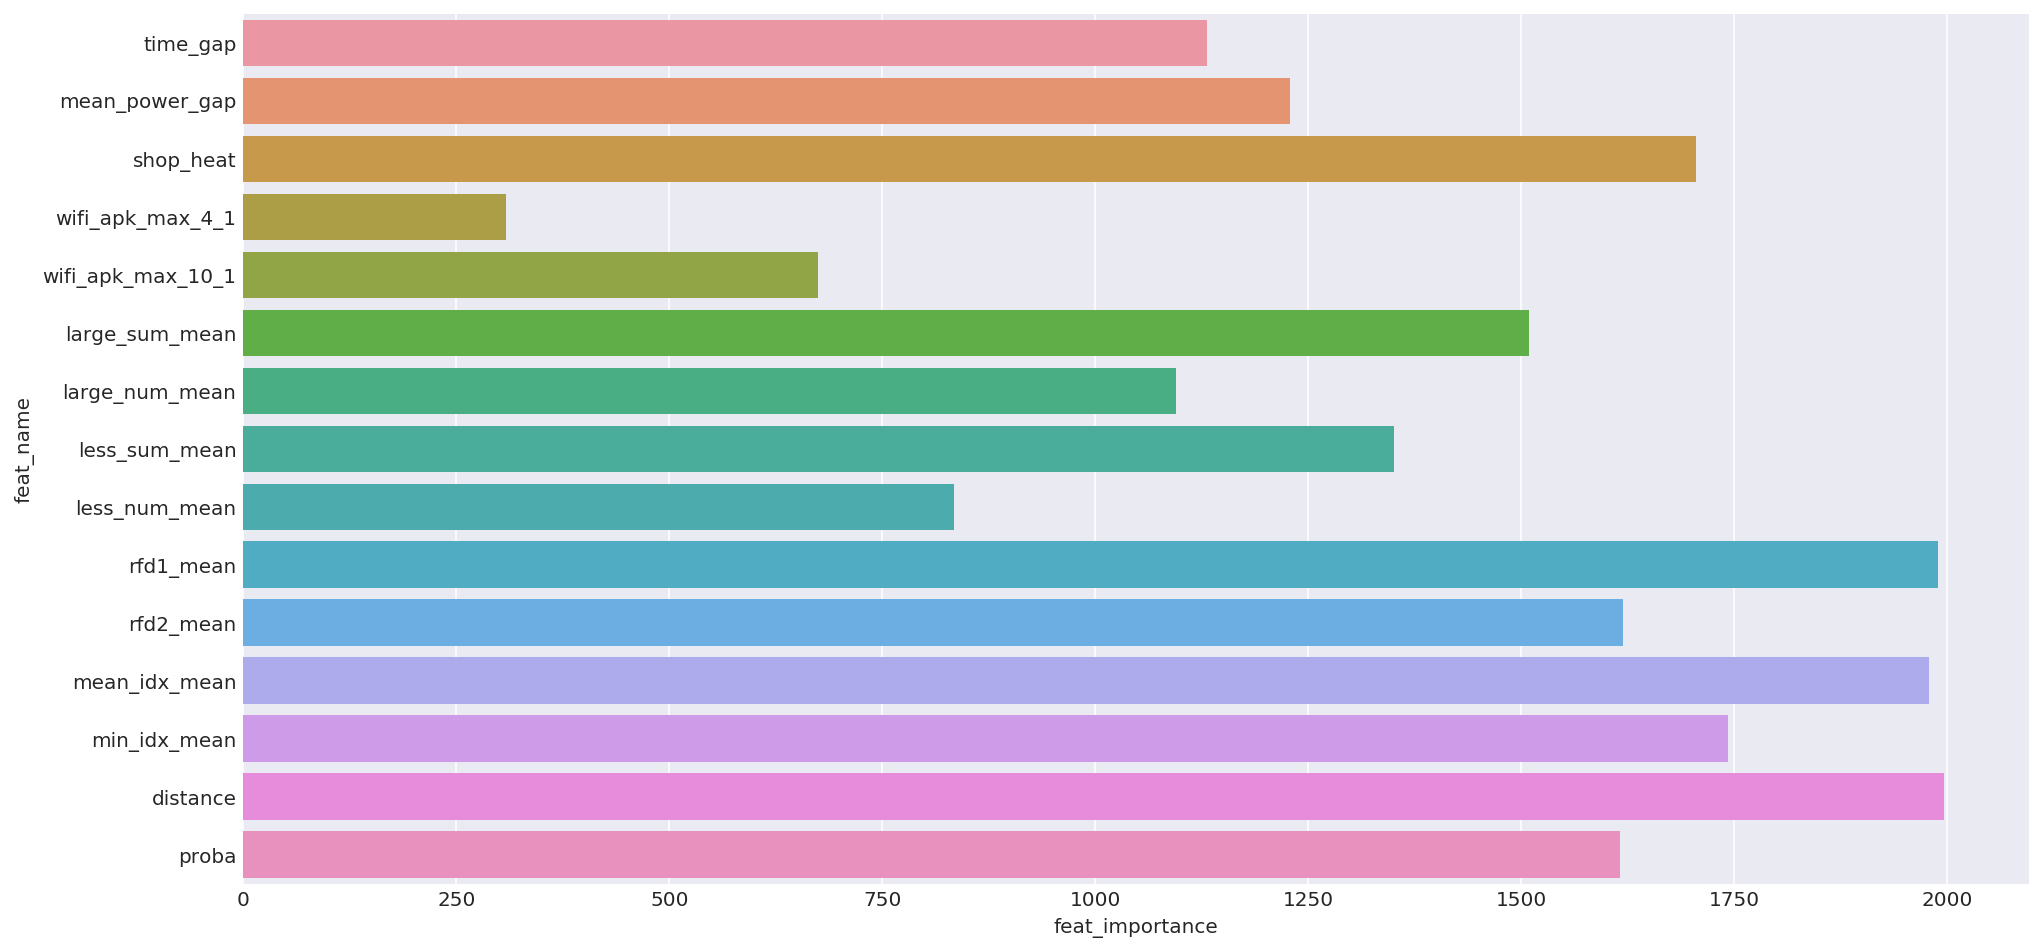

In [45]:
# 特征重要程度
sns.set({'figure.figsize':(16,8)})
sns.barplot(data=pd.DataFrame({'feat_name':train.columns,'feat_importance':model.feature_importance()}),x='feat_importance',y='feat_name')

In [43]:
# 测试
proba=model.predict(test)
ans=pd.DataFrame({'row_id':test_basic['row_id'],'shop_id':test_basic['shop_id'],'proba':proba})
# 保存结果文件
tmp=ans.sort_values('proba').groupby('row_id',as_index=False).tail(1)
tmp=pd.merge(test_df[['row_id']],tmp[['row_id','shop_id']],on='row_id',how='left')
tmp.fillna('s_4941',inplace=True)
tmp.to_csv('result.csv',index=False,sep=',')